# SNPs: Efast sensitivity analysis

In [1]:
from SALib.sample import saltelli, fast_sampler
import pandas as pd
import binsreg as br
from Sensitivity import Sensitivity
import joblib

model_path = "../models/BMI-SNP/"
output_path = "../output/data/"
plots_path = "../output/plots/"

In [2]:
# parameter dictionary
problem = {
    'num_vars': 3,
    'names': ['random-mating', 'genetic-variance', 'fertility-differential'],
    'bounds': [[0, 1.0],
               [0, 0.50],
               [0, 0.30]]
}

In [3]:
sample_parameters = False
if (sample_parameters):
    param_values = fast_sampler.sample(problem, 2000)
    t = pd.DataFrame(param_values)
    t.columns = ['random-mating', 'genetic-variance', 'fertility-differential']
    t.to_csv(model_path + "data/param-snp-efast-test.csv", index=False)
else:
    t = pd.read_csv(model_path + "data/param-snp-efast-test.csv")
t.shape

(6000, 3)

In [4]:
# read data
df = pd.read_csv(output_path + "results-snp-efast-test.csv", sep = ";")
cols = df.bmi_category_prop.str.replace(r'\[|\]', '').str.split(",", n=4, expand=True)
colnames = ['g'+str(i+1) for i in range(4)]
cols.columns = colnames
cols = cols[colnames].apply(pd.to_numeric)
df = pd.concat([df, cols], axis=1, ignore_index=False)
params = pd.read_csv(output_path + "param-snp-efast-test.csv", sep = ";")
df = df.merge(params, on = ["iteration", "replicate"])
df["iteration"] = pd.to_numeric(df["iteration"])
df = df.sort_values(by=['iteration'])
df = df.loc[df["iteration"] <= len(t),:]

# select parameters
vars = ['p_fertility_factor', 'p_random_mating', 'p_genetic_variance']
X = df.loc[:,vars]

/var/folders/36/wsfqn0_j2ng6r0b58wc559fc0000gn/T/ipykernel_26414/932945288.py:3: FutureWarning: The default value of regex will change from True to False in a future version.


In [5]:
X.describe()

,p_fertility_factor,p_random_mating,p_genetic_variance
count,6000.000000,6000.000000,6000.000000
mean,0.150000,0.500000,0.250000
std,0.086610,0.288699,0.144350
min,0.000011,0.000036,0.000018
25%,0.075005,0.250018,0.125009
50%,0.150000,0.500000,0.250000
75%,0.224995,0.749982,0.374991
max,0.299989,0.999964,0.499982


## Proportion obese

                              S1        ST   S1_conf   ST_conf
random-mating           0.108705  0.236586  0.003799  0.016742
genetic-variance        0.475521  0.688804  0.003624  0.018234
fertility-differential  0.184350  0.336495  0.003542  0.018699


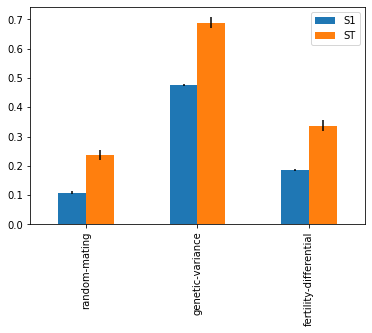

In [6]:
ef = Sensitivity(problem, df['g4'], X)
ef.score('efast')
ef.plot(save=True, filepath= plots_path + 'snp-efast-prop-obese.pdf',
    move=True, moving_path= '../manuscript/plots/')
ef.plot3D(labels={'outcome':'obese', 'y':'random mating', 'x':'fertility', 'z':'genes'})

sav = {
    'ef_obese_s1': ef.tabval('S1'),
    'ef_obese_st': ef.tabval('ST')
}

In [7]:
# df_est = br.binsreg(x="p_genetic_variance", y="average_bmi", w = ["p_random_mating", "p_fertility_factor"], at="median", data=df)
# df_est.bins_plot

# df_est = br.binsreg(x="p_random_mating", y="average_bmi", w=["p_genetic_variance", 'p_fertility_factor'],at="median", data=df)
# df_est.bins_plot

# df_est = br.binsreg(x="p_fertility_factor", y="average_bmi",  w=["p_genetic_variance", 'p_random_mating'], data=df)
# df_est.data_plot[0]

## Average BMI

                              S1        ST   S1_conf   ST_conf
random-mating           0.097476  0.187843  0.003400  0.020599
genetic-variance        0.502342  0.666634  0.003872  0.017895
fertility-differential  0.223184  0.348994  0.004410  0.018096


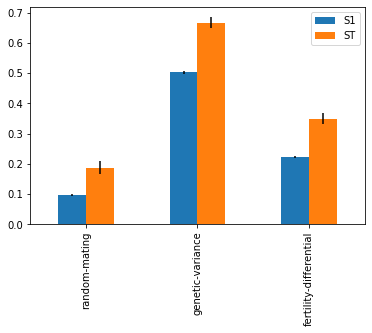

In [8]:
ef = Sensitivity(problem, df['average_bmi'], X)
ef.score('efast')
ef.plot(save=True, filepath= plots_path + 'snp-efast-average-bmi.pdf',
    move=True, moving_path= '../manuscript/plots/')
ef.plot3D(labels={'outcome':'average bmi', 'y':'random mating', 'x':'fertility', 'z':'genes'})
sav['ef_avg_s1'] = ef.tabval('S1')
sav['ef_avg_st'] = ef.tabval('ST')


## SD BMI

                              S1        ST   S1_conf   ST_conf
random-mating           0.160195  0.501422  0.003811  0.019396
genetic-variance        0.345587  0.736616  0.004492  0.015571
fertility-differential  0.065233  0.335602  0.003902  0.015861


['efast-snp.pkl']

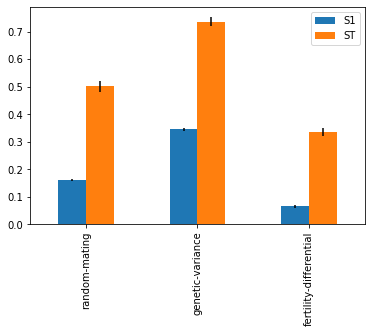

In [9]:
ef = Sensitivity(problem, df['sd_bmi'], X)
ef.score('efast')
ef.plot(save=True, filepath= plots_path + 'snp-efast-sd-bmi.pdf',
    move=True, moving_path= '../manuscript/plots/')
ef.plot3D(labels={'outcome':'sd bmi', 'y':'random mating', 'x':'fertility', 'z':'genes'})

sav['ef_sd_s1'] = ef.tabval('S1')
sav['ef_sd_st'] = ef.tabval('ST')

# save output
v = ef.createRows(sav)
joblib.dump(v, 'efast-snp.pkl')